In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch

In [2]:
from get_data import Parser
btc_parcer = Parser('btc_usd')

In [3]:
df = btc_parcer.get_live_data(10)

In [4]:
df

,currency,type,days until expiration,strike,mark_price,iv,underlying_price
0,BTC,call,226,60000,0.0473,1.1040,16741.03
1,BTC,put,44,35000,1.1164,0.9071,16741.03
2,BTC,call,72,23000,0.0953,1.1594,16741.03
3,BTC,put,2,23000,0.3792,1.3182,16741.03
4,BTC,put,1,16750,0.0255,0.8412,16741.03
...,...,...,...,...,...,...,...
1,BTC,put,44,55000,2.3177,1.1576,16780.73
2,BTC,put,44,150000,8.0483,2.1000,16780.73
3,BTC,call,44,15000,0.1595,0.7918,16780.73
4,BTC,call,16,18000,0.1481,2.1000,16780.73


In [202]:
df.to_csv('df.csv')

In [2]:
df = pd.read_csv('df.csv')

In [4]:
maturities = np.sort(np.unique(df['days until expiration'].values))
x = []
y = []
call_prices = []
for maturity in maturities:
    indicies = (df['days until expiration'] == maturity) & (df['type'] == 'call')
    x.append(torch.Tensor(np.array([df['strike'][indicies].values,df['underlying_price'][indicies].values,
                df['days until expiration'][indicies].values/365])))
    y.append(torch.Tensor(df['iv'][indicies].values))
    call_prices.append((df['mark_price'][indicies].values)*(df['underlying_price'][indicies].values))

In [3]:
from SABR import SABR
sabr = SABR()
f = sabr.sigma_SABR

In [5]:
from Levenberg_Marquardt import Levenberg_Marquardt

initial_params = torch.rand(3)
lm = []
losses = []
params = []
for i in range(len(maturities)):
    lm.append(Levenberg_Marquardt(y[i], x[i], f, initial_params))
    _losses, _params = lm[i].fit(100)
    losses.append(_losses)
    params.append(_params.clone())

<IPython.core.display.Javascript object>


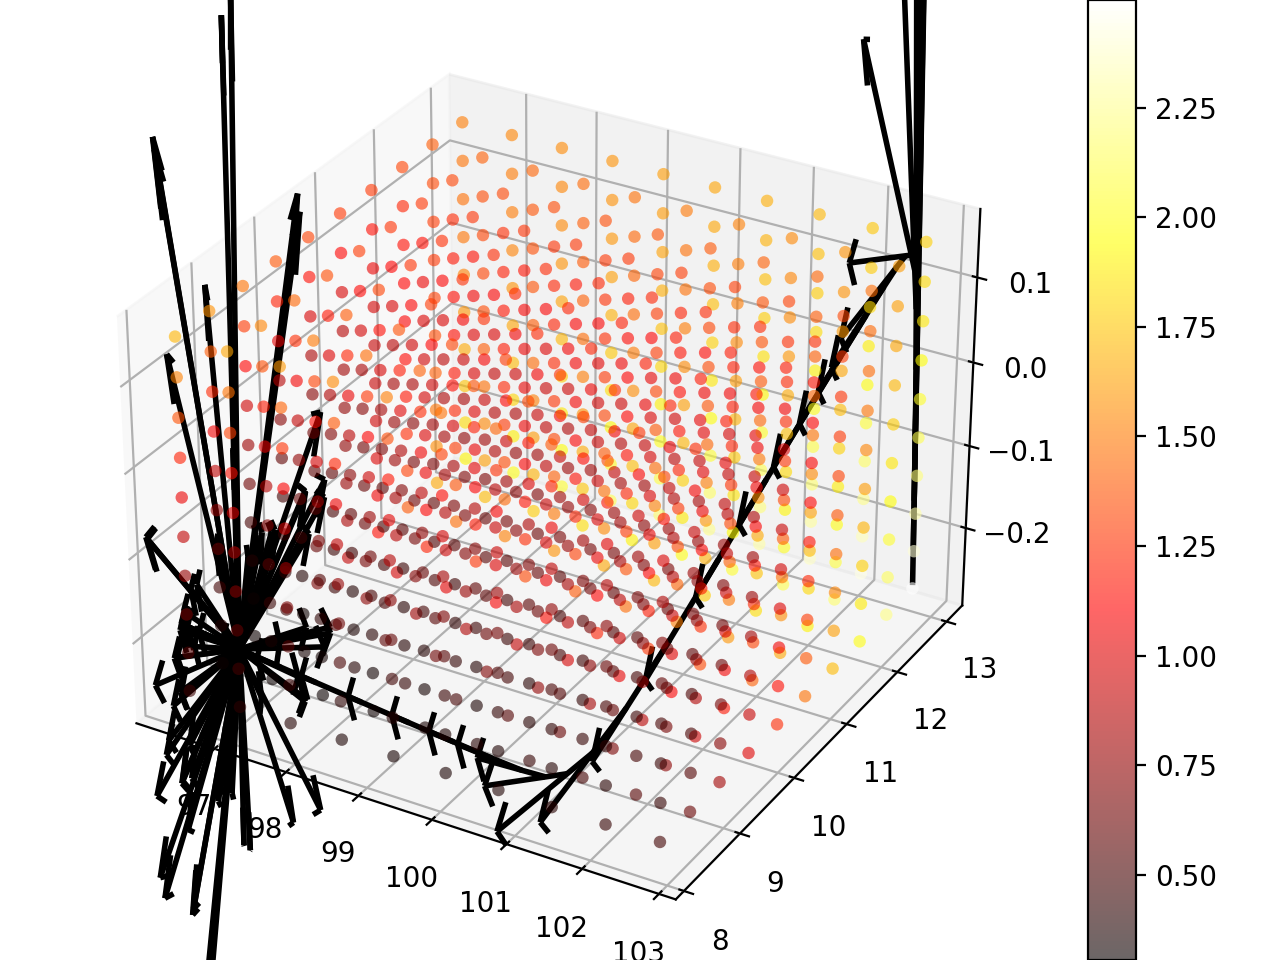

In [6]:
%matplotlib notebook
lm[2].visualize()

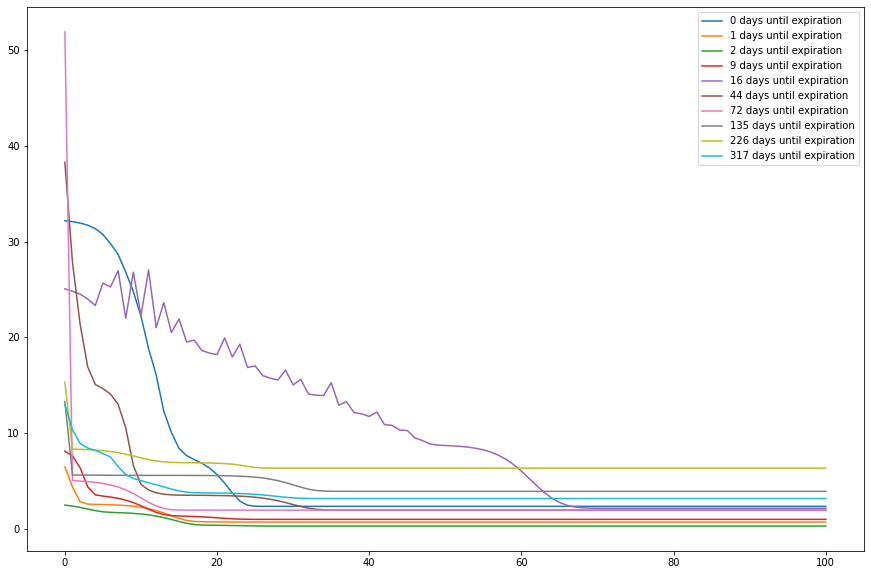

In [7]:
%matplotlib inline
labels = [str(maturity)+" days until expiration" for maturity in maturities]
fig = plt.figure(figsize = (15,10))
for i in range(len(losses)):
    plt.plot(np.arange(len(losses[i])), losses[i], label = labels[i])
plt.legend(loc="upper right")
plt.show();

In [70]:
params_list = [_params.tolist() for _params in params]
params_df = pd.DataFrame(params_list, columns =['alpha', 'nu', 'rho'])
params_df['maturity, years'] = maturities/365
params_df

,alpha,nu,rho,"maturity, years"
0,106.346176,18.706083,-0.263473,0.000000
1,102.750717,12.979197,-0.261701,0.002740
2,96.357346,9.009489,-0.265811,0.005479
3,84.909119,4.833162,0.115954,0.024658
4,219.288666,6.766765,0.124008,0.043836
5,458.081512,12.785237,-0.865933,0.120548
6,464.563293,6.798603,-0.836273,0.197260
7,171.388565,8.068833,-0.838798,0.369863
8,123.509430,1.620408,-0.144932,0.619178
9,234.448227,8.195399,-0.774797,0.868493


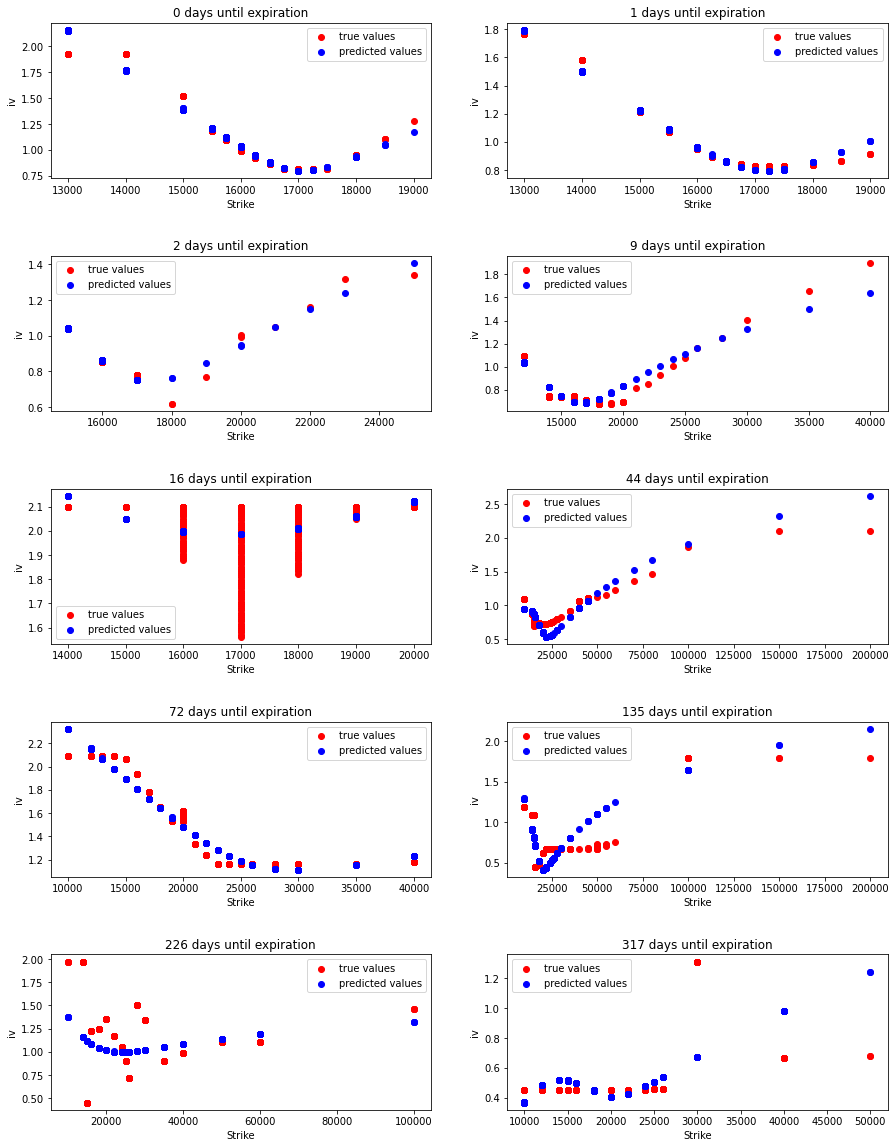

In [196]:
%matplotlib inline
ax = [0]
fig = plt.figure(figsize = (15,20)) 
fig.tight_layout(pad=10.0)

for i in range(len(maturities)):
# create figure window

    gs = gridspec.GridSpec(5, 2)
    gs.update(wspace = 0.2, hspace = 0.5)
# Creates grid 'gs' of a rows and b columns 

    ax[i] = plt.subplot(gs[(i)//2, (i)%2])
# Adds subplot 'ax' in grid 'gs' at position [x,y]


    ax[i].set_ylabel('iv') 
    ax[i].set_xlabel('Strike') 

    ax[i].scatter(x[i][0], y[i], color = 'r', label = 'true values')
    ax[i].scatter(x[i][0], f(params[i], x[i]), color = 'b', label = 'predicted values')
    ax[i].title.set_text(labels[i])
    ax[i].legend()
    fig.add_subplot(ax[i]) #add 'ax' to figure
    ax.append([0])

   


In [148]:
strikes = []
mats = []
ivs = []
true_ivs = []
for i in range(len(x)):
    ivs.extend(f(params[i], x[i]).tolist())
    mats.extend([maturities[i] for j in range(len(x[i][0]))])
    strikes.extend(x[i][0].tolist())
    true_ivs.extend(y[i])
    
ivs = np.array(ivs)
mats = np.array(mats)
strikes = np.array(strikes)

<IPython.core.display.Javascript object>


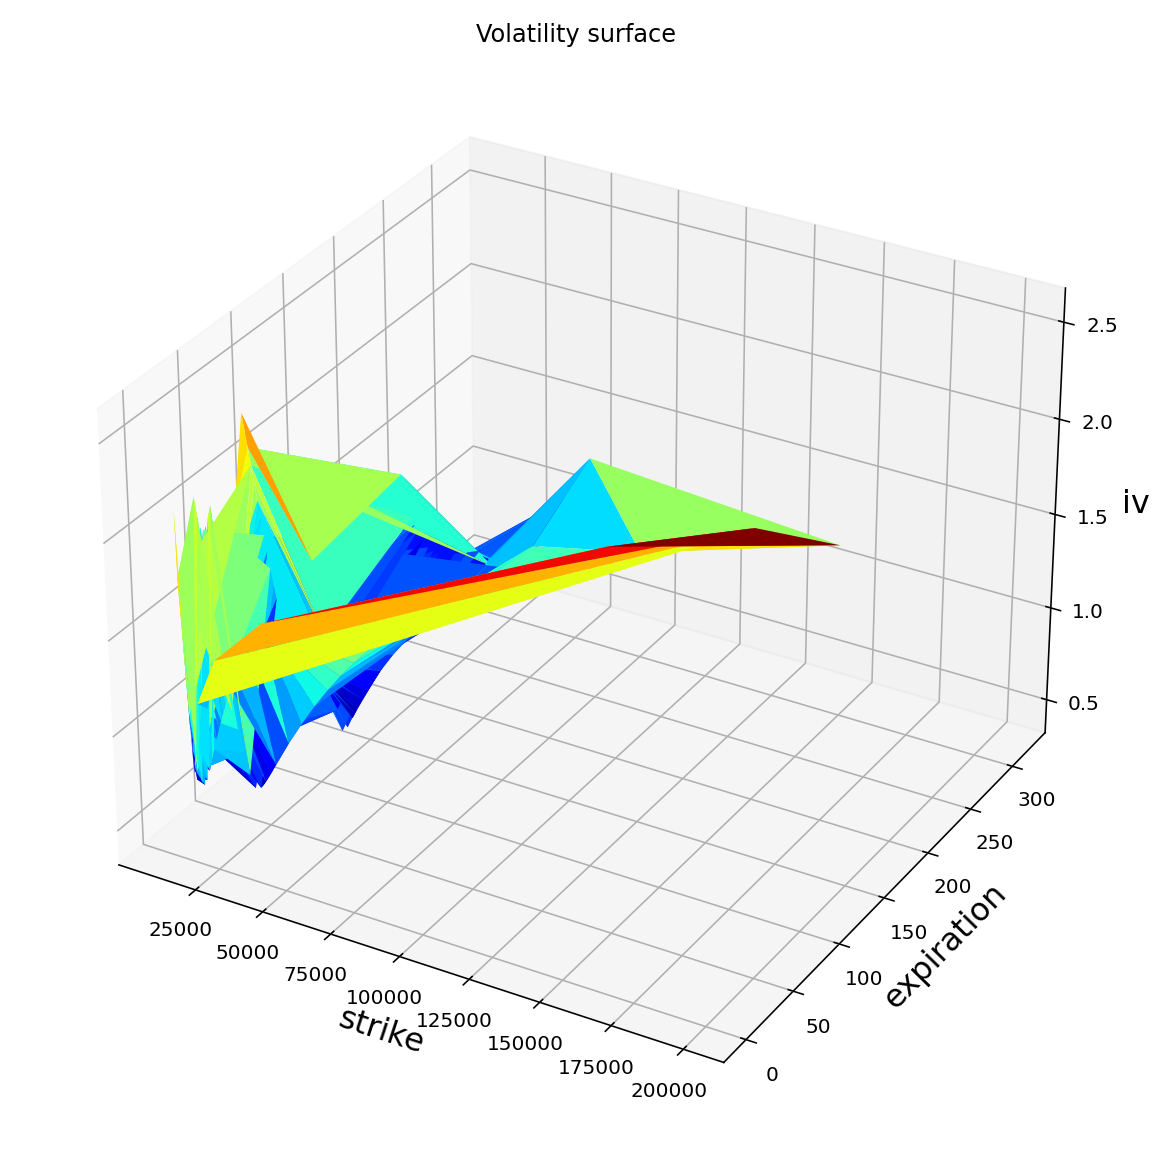

In [200]:
%matplotlib notebook
from matplotlib import cm
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("strike", fontsize=16)
ax.set_ylabel("expiration", fontsize=16)
ax.set_zlabel("iv", fontsize=16)



ax.plot_trisurf(strikes, mats, ivs,  cmap=cm.jet, linewidth=0.5)
#ax.scatter(strikes, mats, true_ivs)
plt.title('Volatility surface')

plt.tight_layout()
 
plt.show()

<IPython.core.display.Javascript object>


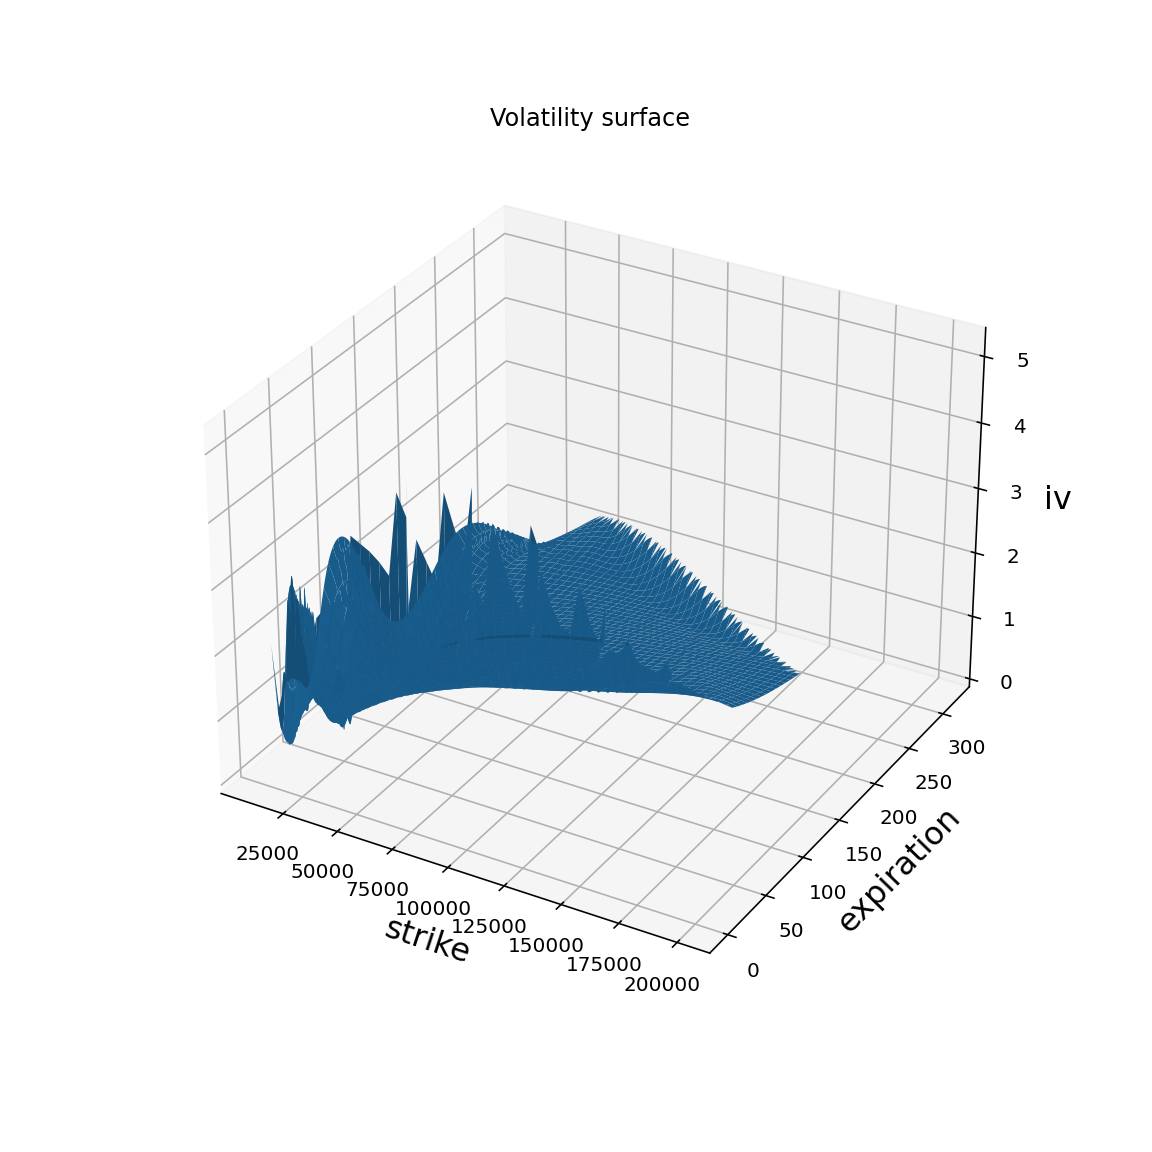

/var/folders/2s/5x_hb7c12t5g5wy3qgqdq1k40000gn/T/ipykernel_58536/1551504092.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xig, yig, zi)


In [204]:
from scipy.interpolate import griddata
   
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("strike", fontsize=16)
ax.set_ylabel("expiration", fontsize=16)
ax.set_zlabel("iv", fontsize=16)

xi = np.linspace(strikes.min(),strikes.max(),(len(ivs)//3))
yi = np.linspace(mats.min(),mats.max(),(len(ivs)//3))

zi = griddata((strikes, mats), ivs, (xi[None,:], yi[:,None]), method='cubic', rescale=True)

xig, yig = np.meshgrid(xi, yi)

surf = ax.plot_surface(xig, yig, zi)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Volatility surface')
plt.savefig('Volatility surface.png')
plt.show()

In [10]:
fit_call_prices = []
for i in range(len(maturities)):
    sabr.set_params(params[i])
    fit_call_prices.append(sabr.bs_call(x[i]))

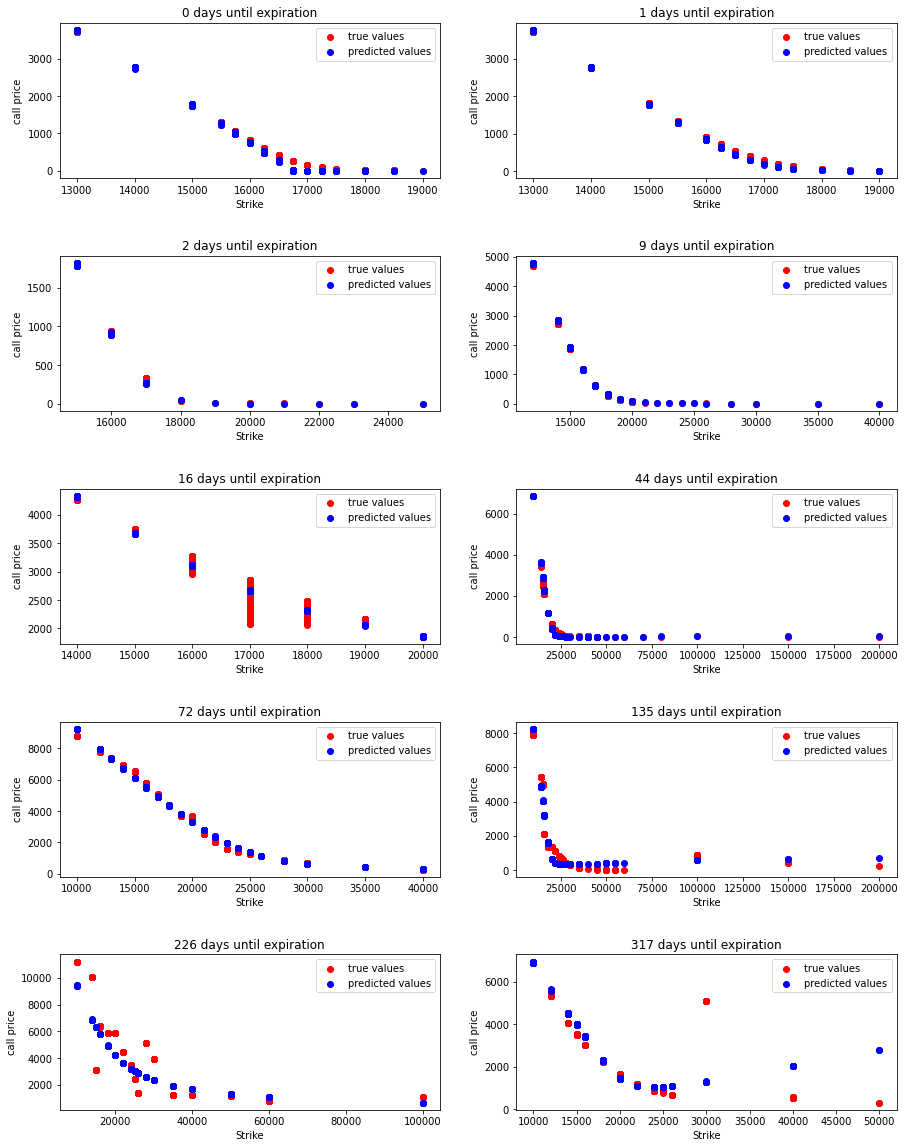

In [11]:
%matplotlib inline
ax = [0]
fig = plt.figure(figsize = (15,20)) 
fig.tight_layout(pad=10.0)

for i in range(len(maturities)):
# create figure window

    gs = gridspec.GridSpec(5, 2)
    gs.update(wspace = 0.2, hspace = 0.5)
# Creates grid 'gs' of a rows and b columns 

    ax[i] = plt.subplot(gs[(i)//2, (i)%2])
# Adds subplot 'ax' in grid 'gs' at position [x,y]


    ax[i].set_ylabel('call price') 
    ax[i].set_xlabel('Strike') 

    ax[i].scatter(x[i][0], call_prices[i], color = 'r', label = 'true values')
    ax[i].scatter(x[i][0], fit_call_prices[i], color = 'b', label = 'predicted values')
    ax[i].title.set_text(labels[i])
    ax[i].legend()
    fig.add_subplot(ax[i]) #add 'ax' to figure
    ax.append([0])

In [13]:
np.save('params.npy', params, allow_pickle = True)